# 广告预测

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.sans-serif"] = ["SimHei"]  # 指定中文字体

# 读取 CSV 文件
data = pd.read_csv("data/house_sales.csv")
print('数据基本信息：')
data.info()



数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   date           10000 non-null  object 
 2   price          10000 non-null  float64
 3   bedrooms       10000 non-null  int64  
 4   bathrooms      10000 non-null  int64  
 5   sqft_living    10000 non-null  int64  
 6   sqft_lot       10000 non-null  int64  
 7   floors         10000 non-null  int64  
 8   waterfront     10000 non-null  int64  
 9   view           10000 non-null  int64  
 10  condition      10000 non-null  int64  
 11  grade          10000 non-null  int64  
 12  sqft_above     10000 non-null  int64  
 13  sqft_basement  10000 non-null  int64  
 14  yr_built       10000 non-null  int64  
 15  yr_renovated   10000 non-null  int64  
 16  zipcode        10000 non-null  int64  
 17  lat            10000 non-null  float64
 18 

In [7]:
# 检查缺失值
missing_values = data.isnull().sum()
print('各列缺失值数量：')
print(missing_values)

# 处理缺失值，这里简单地删除包含缺失值的行
data = data.dropna()

# 检查异常值，以房价为例，使用 IQR 方法
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]


各列缺失值数量：
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
dtype: int64


In [8]:
# 将日期列转换为日期类型
data['date'] = pd.to_datetime(data['date'])


In [9]:
# 计算房屋的使用年限
data['age'] = data['date'].dt.year - data['yr_built']
# 创建新特征：是否翻新
data['is_renovated'] = data['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)


In [10]:
# 选择数值型列
numeric_columns = data.select_dtypes(include=[np.number]).columns
# 计算描述性统计信息
description = data[numeric_columns].describe(percentiles=[0.25, 0.5, 0.75])
print('数值型列的描述性统计：')
print(description)


数值型列的描述性统计：
                 id          price     bedrooms    bathrooms  sqft_living  \
count   9930.000000    9930.000000  9930.000000  9930.000000  9930.000000   
mean    5001.107049  501121.772151     4.496878     3.521349  2906.238671   
std     2885.966447   97124.951211     2.297853     1.727304  1210.034706   
min        1.000000  229983.900000     1.000000     1.000000   801.000000   
25%     2503.250000  433529.705000     2.000000     2.000000  1865.000000   
50%     5001.500000  501561.090000     4.000000     4.000000  2909.000000   
75%     7496.750000  567653.252500     7.000000     5.000000  3957.000000   
max    10000.000000  770223.220000     8.000000     6.000000  5000.000000   

           sqft_lot       floors   waterfront         view    condition  \
count   9930.000000  9930.000000  9930.000000  9930.000000  9930.000000   
mean    5520.495065     1.999295     0.498489     2.016314     2.985901   
std     2604.054446     0.819431     0.500023     1.418670     1.4161

In [11]:
# 计算不同特征与房价的相关性
correlation = data[numeric_columns].corr()
print('各特征与房价的相关性：')
print(correlation['price'])


各特征与房价的相关性：
id               0.011216
price            1.000000
bedrooms         0.004881
bathrooms        0.008096
sqft_living      0.011616
sqft_lot         0.003644
floors          -0.005926
waterfront       0.001748
view            -0.002817
condition        0.001813
grade            0.004603
sqft_above      -0.005068
sqft_basement   -0.003476
yr_built         0.012998
yr_renovated    -0.000186
zipcode          0.007931
lat             -0.001472
long            -0.006436
age             -0.004177
is_renovated    -0.000069
Name: price, dtype: float64


In [12]:
# 按邮政编码分组，计算每组的平均房价、平均居住面积、平均卧室数量
zipcode_stats = data.groupby('zipcode').agg({
    'price': 'mean',
    'sqft_living': 'mean',
    'bedrooms': 'mean'
})
zipcode_stats.columns = ['avg_price', 'avg_sqft_living', 'avg_bedrooms']
print('不同邮政编码区域的统计信息：')
print(zipcode_stats)

不同邮政编码区域的统计信息：
             avg_price  avg_sqft_living  avg_bedrooms
zipcode                                              
98001    502211.909176      2917.520854      4.357905
98002    497808.793483      2955.262821      4.554487
98003    497930.512592      2870.403689      4.547131
98004    498747.163954      2857.314854      4.407950
98005    503306.661532      2975.695481      4.548134
98006    505345.428558      2887.992944      4.599798
98007    502716.775391      2900.131553      4.358061
98008    499171.818208      2877.518519      4.499499
98009    500330.593340      2901.382627      4.472596
98010    503083.699933      2916.949234      4.623563


In [13]:
# 按是否翻新分组，计算每组的平均房价、平均居住面积、平均卧室数量
renovation_stats = data.groupby('is_renovated').agg({
    'price': 'mean',
    'sqft_living': 'mean',
    'bedrooms': 'mean'
})
renovation_stats.columns = ['avg_price', 'avg_sqft_living', 'avg_bedrooms']
print('是否翻新分组的统计信息：')
print(renovation_stats)


是否翻新分组的统计信息：
                  avg_price  avg_sqft_living  avg_bedrooms
is_renovated                                              
0             501126.095841      2899.849035      4.506505
1             501111.467479      2921.467121      4.473935


In [14]:
# 按房屋使用年限分组（简单分为 5 个区间）
data['age_group'] = pd.cut(data['age'], bins=5)
age_stats = data.groupby('age_group').agg({
    'price': 'mean',
    'sqft_living': 'mean',
    'bedrooms': 'mean'
})
print('按房屋使用年限分组的统计信息：')
print(age_stats)


按房屋使用年限分组的统计信息：
                        price  sqft_living  bedrooms
age_group                                           
(-0.124, 24.8]  501594.625623  2912.909214  4.511300
(24.8, 49.6]    500933.820999  2912.564145  4.485583
(49.6, 74.4]    501518.890152  2867.016575  4.421271
(74.4, 99.2]    496723.141722  2910.078910  4.628407
(99.2, 124.0]   503413.042977  2926.920930  4.358140


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26652\1187709744.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = data.groupby('age_group').agg({


In [15]:
# 按年份分组，计算每年的平均房价
yearly_avg_price = data.groupby(data['date'].dt.year)['price'].mean()
print('每年的平均房价：')
print(yearly_avg_price)


每年的平均房价：
date
1900    488884.680000
1902    513972.100000
1903    509519.793333
1905    522640.340000
1906    470978.868333
            ...      
2020    512492.021111
2021    494507.942625
2022    498970.821277
2023    502406.178047
2024    499999.391169
Name: price, Length: 123, dtype: float64


In [16]:
# 按年份和是否翻新分组，计算每年不同翻新情况的平均房价
yearly_renovation_avg_price = data.groupby([data['date'].dt.year, 'is_renovated'])['price'].mean()
print('每年不同翻新情况的平均房价：')
print(yearly_renovation_avg_price)


每年不同翻新情况的平均房价：
date  is_renovated
1900  0               488884.680000
1902  0               513972.100000
1903  0               445335.310000
      1               637888.760000
1905  0               522640.340000
                          ...      
2022  1               484070.180990
2023  0               502393.039380
      1               502439.298437
2024  0               497149.856014
      1               505383.902403
Name: price, Length: 240, dtype: float64


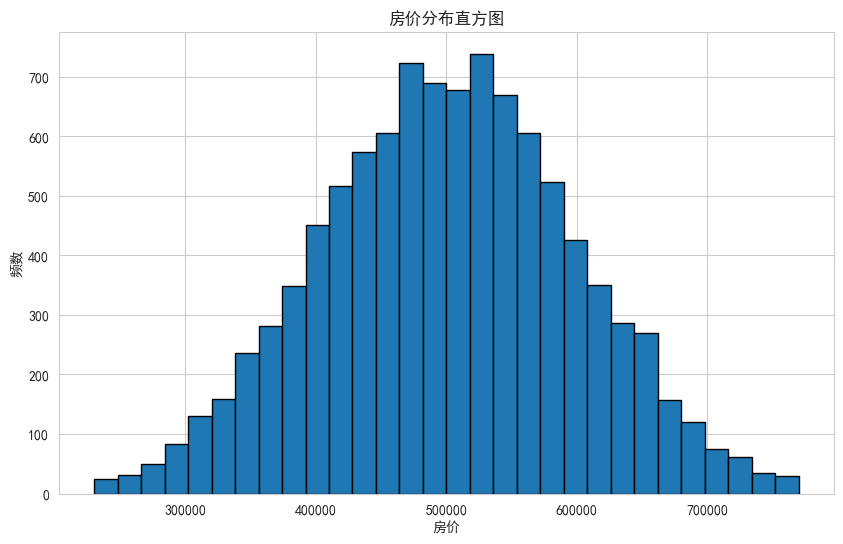

In [18]:
# 房价分布直方图
plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=30, edgecolor='k')
plt.title('房价分布直方图')
plt.xlabel('房价')
plt.ylabel('频数')
plt.show()


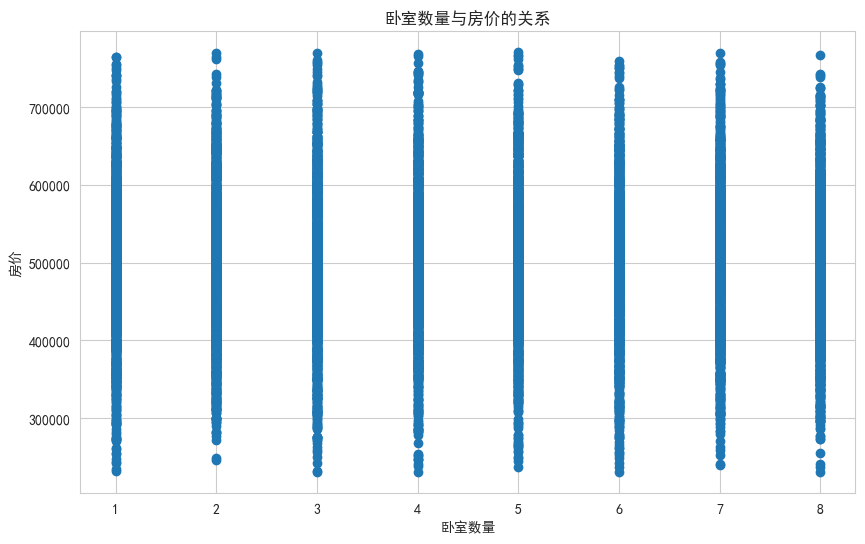

In [19]:
# 卧室数量与房价的散点图
plt.figure(figsize=(10, 6))
plt.scatter(data['bedrooms'], data['price'])
plt.title('卧室数量与房价的关系')
plt.xlabel('卧室数量')
plt.ylabel('房价')
plt.show()


D:\conda\envs\nlp\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


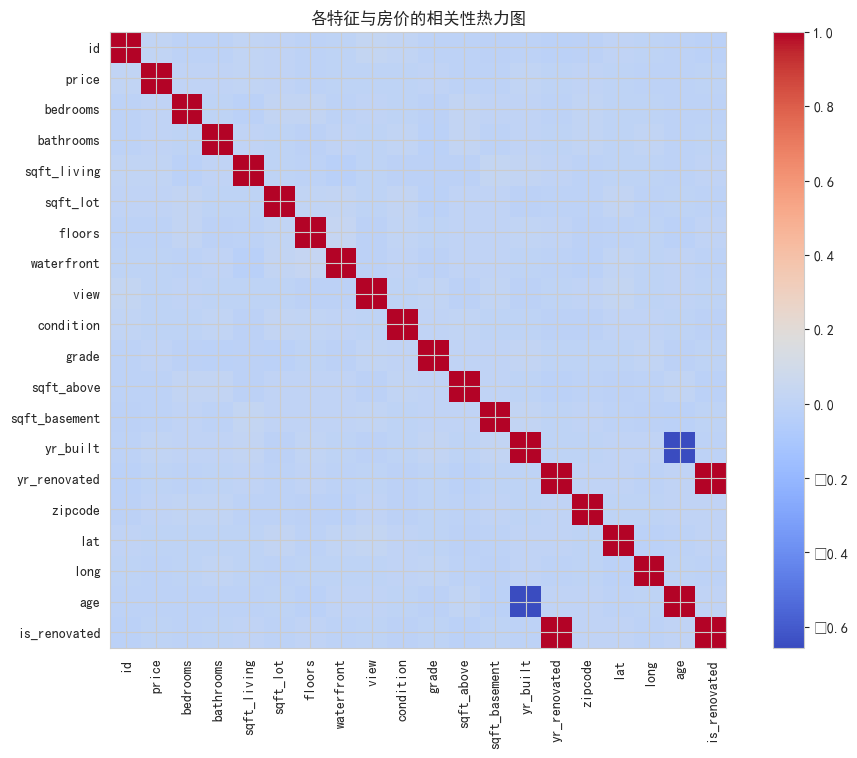

In [20]:
# 各特征与房价的相关性热力图
plt.figure(figsize=(12, 8))
plt.imshow(correlation, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.title('各特征与房价的相关性热力图')
plt.show()


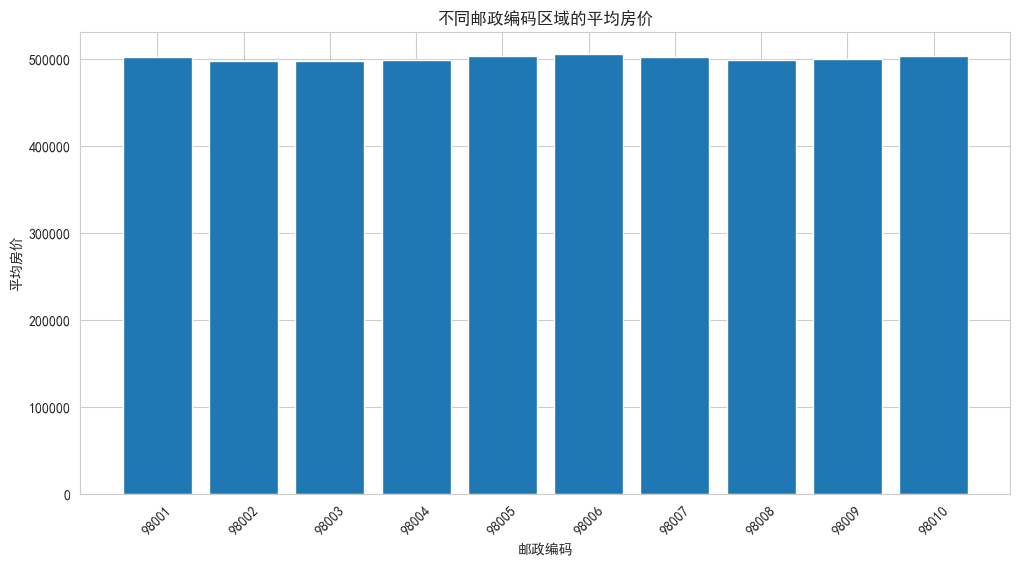

In [21]:
# 不同邮政编码区域平均房价的柱状图
plt.figure(figsize=(12, 6))
plt.bar(zipcode_stats.index.astype(str), zipcode_stats['avg_price'])
plt.title('不同邮政编码区域的平均房价')
plt.xlabel('邮政编码')
plt.ylabel('平均房价')
plt.xticks(rotation=45)
plt.show()


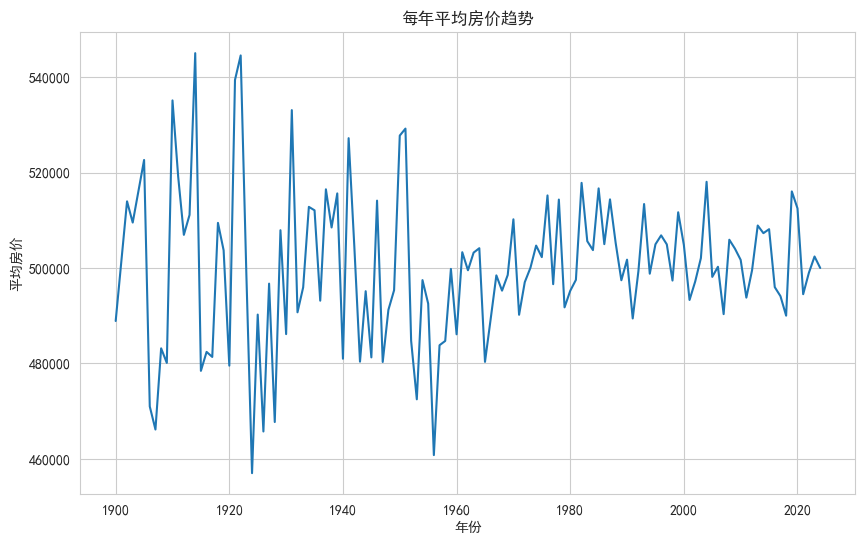

In [22]:
# 每年平均房价的折线图
plt.figure(figsize=(10, 6))
plt.plot(yearly_avg_price.index, yearly_avg_price)
plt.title('每年平均房价趋势')
plt.xlabel('年份')
plt.ylabel('平均房价')
plt.show()


<Figure size 1000x600 with 0 Axes>

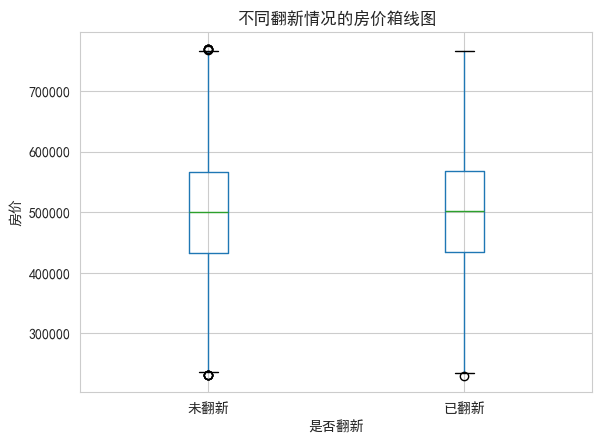

In [23]:
# 不同翻新情况的房价箱线图
plt.figure(figsize=(10, 6))
data.boxplot(column='price', by='is_renovated')
plt.title('不同翻新情况的房价箱线图')
plt.xlabel('是否翻新')
plt.xticks([1, 2], ['未翻新', '已翻新'])
plt.ylabel('房价')
plt.suptitle('')  # 去掉默认的标题
plt.show()


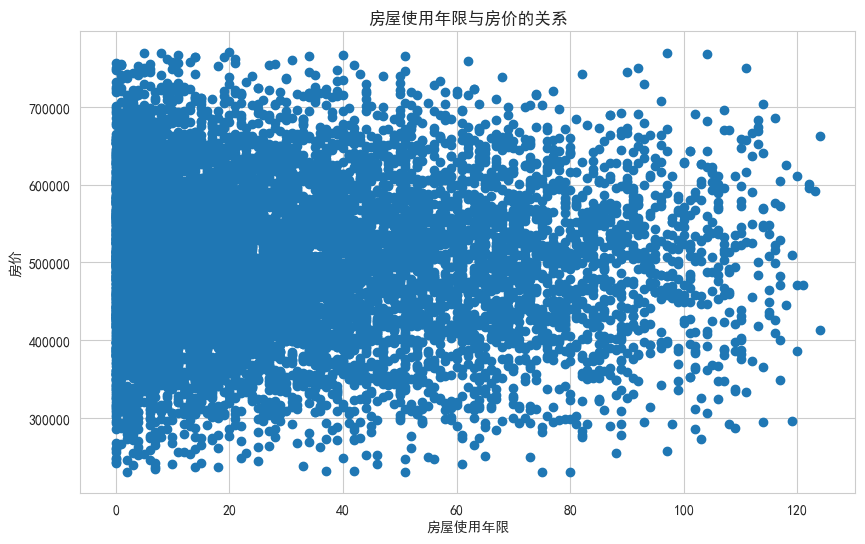

In [24]:
# 房屋使用年限与房价的散点图
plt.figure(figsize=(10, 6))
plt.scatter(data['age'], data['price'])
plt.title('房屋使用年限与房价的关系')
plt.xlabel('房屋使用年限')
plt.ylabel('房价')
plt.show()


# 心脏病预测

In [25]:
import pandas as pd

# 加载数据集
heart_disease = pd.read_csv("data/heart_disease.csv")
# 处理缺失值
heart_disease.dropna()
heart_disease.info()
heart_disease.head()
from sklearn.model_selection import train_test_split

# 划分特征和标签
X = heart_disease.drop("是否患有心脏病", axis=1)  # 特征
y = heart_disease["是否患有心脏病"]  # 标签
# 将数据集按7:3划分为训练数据与测试数据
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   年龄        1025 non-null   int64  
 1   性别        1025 non-null   int64  
 2   胸痛类型      1025 non-null   int64  
 3   静息血压      1025 non-null   int64  
 4   胆固醇       1025 non-null   int64  
 5   空腹血糖      1025 non-null   int64  
 6   静息心电图结果   1025 non-null   int64  
 7   最大心率      1025 non-null   int64  
 8   运动性心绞痛    1025 non-null   int64  
 9   运动后的ST下降  1025 non-null   float64
 10  峰值ST段的斜率  1025 non-null   int64  
 11  主血管数量     1025 non-null   int64  
 12  地中海贫血     1025 non-null   int64  
 13  是否患有心脏病   1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 数值型特征标准化
numerical_features = ["年龄", "静息血压", "胆固醇", "最大心率", "运动后的ST下降", "主血管数量"]
# 类别型特征
categorical_features = ["胸痛类型", "静息心电图结果", "峰值ST段的斜率", "地中海贫血"]
# 二元特征
binary_features = ["性别", "空腹血糖", "运动性心绞痛"]
# 创建列转换器
preprocessor = ColumnTransformer(
    transformers=[
        # 对数值型特征进行标准化
        ("num", StandardScaler(), numerical_features),
        # 对类别型特征进行独热编码，使用drop="first"避免多重共线性
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        # 二元特征不进行处理
        ("binary", "passthrough", binary_features),
    ]
)
# 执行特征转换
x_train = preprocessor.fit_transform(x_train)  # 计算训练集的统计信息并进行转换
x_test = preprocessor.transform(x_test)  # 使用训练集计算的信息对测试集进行转换


In [27]:
from sklearn.neighbors import KNeighborsClassifier

# 使用K近邻分类模型，K=3
knn = KNeighborsClassifier(n_neighbors=3)
# 模型训练
knn.fit(x_train, y_train)
# 模型评估，计算准确率
knn.score(x_test, y_test)
import joblib

joblib.dump(knn, "knn_heart_disease")
# 加载模型
knn_loaded = joblib.load("knn_heart_disease")
# 预测
y_pred = knn_loaded.predict(x_test[10:11])
# 打印真实值与预测值
print(y_test.iloc[10], y_pred)


0 [0]


# 网格搜索

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
# 网格搜索参数，K值设置为1到10
param_grid = {"n_neighbors": list(range(1, 10))}
# GridSearchCV(estimator=模型, param_grid=网格搜索参数, cv=k折交叉验证)
knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10)

# 模型训练
knn.fit(x_train, y_train)
print(pd.DataFrame(knn.cv_results_))  # 所有交叉验证结果
print(knn.best_estimator_)  # 最佳模型
print(knn.best_score_)  # 最佳得分

# 使用最佳模型进行评估
knn = knn.best_estimator_
print(knn.score(x_test, y_test))


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.002600      0.000664         0.014406        0.004080   
1       0.001599      0.000664         0.009879        0.000802   
2       0.002098      0.000701         0.066664        0.080507   
3       0.002237      0.001076         0.015574        0.013948   
4       0.001799      0.000399         0.009051        0.001023   
5       0.001499      0.000499         0.009203        0.001326   
6       0.001500      0.000670         0.009302        0.000780   
7       0.001690      0.000636         0.009856        0.001488   
8       0.001495      0.000501         0.009752        0.000920   

   param_n_neighbors              params  split0_test_score  \
0                  1  {'n_neighbors': 1}           0.986111   
1                  2  {'n_neighbors': 2}           0.930556   
2                  3  {'n_neighbors': 3}           0.888889   
3                  4  {'n_neighbors': 4}           0.861111   
4             

# 手写数字识别——逻辑回归

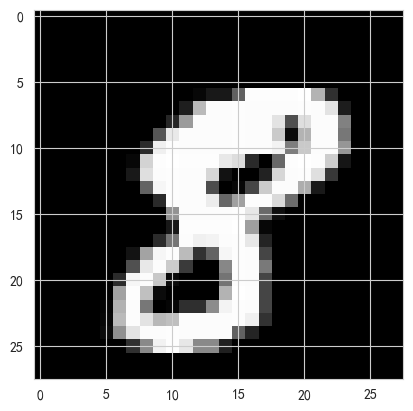

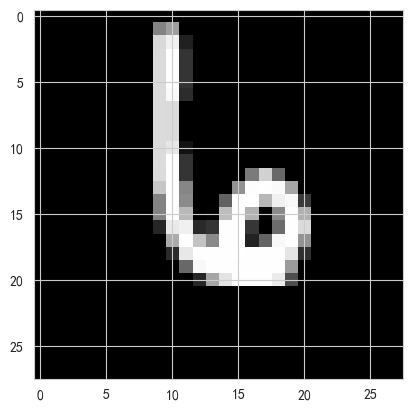

[6]


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# 加载数据集
digit = pd.read_csv("data/train.csv")
plt.imshow(digit.iloc[10, 1:].values.reshape(28, 28), cmap="gray")
plt.show()
# 划分训练集和测试集
X = digit.drop("label", axis=1)  # 特征
y = digit["label"]  # 标签
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 归一化
preprocessor = MinMaxScaler()
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

# 模型训练
model = LogisticRegression(max_iter=500)
model.fit(x_train, y_train)

# 模型评估
model.score(x_test, y_test)

# 预测
plt.imshow(digit.iloc[123, 1:].values.reshape(28, 28), cmap="gray")
plt.show()
print(model.predict(digit.iloc[123, 1:].values.reshape(1, -1)))
